# Model Emotion Recognition

Implementasi Convolutional Neural Network (CNN) menggunakan PyTorch dan ResNet (Residual Network) yang telah dilatih sebelumnya untuk melakukan pengenalan emosi.

## CNN Pytorch with PreTrained ResNet

**CNN** adalah jenis Deep Learning model yang sangat efektif untuk tugas yang berhubungan dengan pengolahan gambar. **ResNet** adalah jenis network yang ditambahkan khusus untuk memudahkan proses training network.

In [ ]:
# Install packages
%pip install torch torchvision numpy matplotlib torchsummary

## Modifying Pre-trained ResNet Model for Custom Emotion Recognition

https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

In [148]:
from torchvision import models
import torch.nn as nn

model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 8)  # There are 8 different emotions to be recognized

print(model.fc)

Linear(in_features=512, out_features=8, bias=True)


In [60]:
from torchsummary import summary
summary(model, (3, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

## Preparing Dataset and DataLoader

https://www.kaggle.com/datasets/sudarshanvaidya/random-images-for-face-emotion-recognition

In [104]:
from torchvision import datasets, transforms

# Data augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),  # ResNet18 requires 3 channel input
        transforms.RandomHorizontalFlip(),
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [107]:
print(data_transforms['train'])

Compose(
    Grayscale(num_output_channels=3)
    RandomHorizontalFlip(p=0.5)
    Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [108]:
print(data_transforms['val'])

Compose(
    Grayscale(num_output_channels=3)
    Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [126]:
from torch.utils.data import DataLoader

trainset = datasets.ImageFolder(root='dataset/kaggle', transform=data_transforms['train'])
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
trainloader

In [120]:
valset = datasets.ImageFolder(root='dataset/kaggle', transform=data_transforms['val'])
valloader = DataLoader(valset, batch_size=32, shuffle=True)
valloader

In [127]:
dataloaders = {'train': trainloader, 'val': valloader}
print(dataloaders)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7fe0b05121c0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7fe0c019bf10>}


## Visualization of Label Distribution

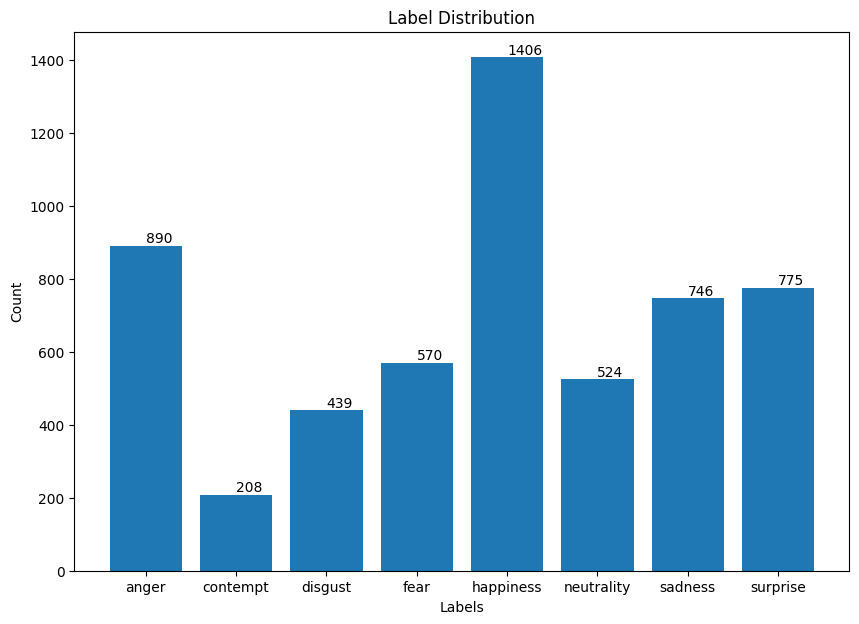

In [145]:
import matplotlib.pyplot as plt
import numpy as np

labels = np.array(trainset.targets)
unique_labels, counts = np.unique(labels, return_counts=True)

plt.figure(figsize=(10,7))
bars = plt.bar(trainset.classes, counts)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom')

plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

In [134]:
import torch

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = nn.CrossEntropyLoss()

print(device)
print(model.parameters())
print(criterion)

cuda:0
<generator object Module.parameters at 0x7fe0b0281580>
CrossEntropyLoss()


In [136]:
import torch.optim as optim

# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [139]:
from torch.optim import lr_scheduler

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

print(exp_lr_scheduler)

## Training and Validation phase

In [ ]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    return running_loss, running_corrects

In [ ]:
running_loss, running_corrects = train_one_epoch(model, dataloaders['train'], criterion, optimizer, device)
print(running_loss, running_corrects)

In [ ]:
def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    return running_loss, running_corrects

In [ ]:
running_loss, running_corrects = validate_one_epoch(model, dataloaders['val'], criterion, device)
print(running_loss, running_corrects)

In [ ]:
import copy

def train_model(model, dataloaders, criterion, optimizer, scheduler, device, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Lists for plot
    train_loss_values = []
    train_acc_values = []
    val_loss_values = []
    val_acc_values = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Training phase
        running_loss, running_corrects = train_one_epoch(model, dataloaders['train'], criterion, optimizer, device)

        scheduler.step()

        epoch_loss = running_loss / len(dataloaders['train'].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders['train'].dataset)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format('train', epoch_loss, epoch_acc))
        train_loss_values.append(epoch_loss)
        train_acc_values.append(epoch_acc)

        # Validation phase
        running_loss, running_corrects = validate_one_epoch(model, dataloaders['val'], criterion, device)

        epoch_loss = running_loss / len(dataloaders['val'].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders['val'].dataset)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format('val', epoch_loss, epoch_acc))
        val_loss_values.append(epoch_loss)
        val_acc_values.append(epoch_acc)

        # deep copy the model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_values, train_acc_values, val_loss_values, val_acc_values, best_acc

In [ ]:
model, train_loss_values, train_acc_values, val_loss_values, val_acc_values, best_acc = train_model(
    model, dataloaders, criterion, optimizer, exp_lr_scheduler, device, num_epochs=25
)

## Visualization

In [9]:
import matplotlib.pyplot as plt

def plot_acc_loss(train_loss_values, val_loss_values, train_acc_values, val_acc_values):
    # moving the tensor to cpu and converting them to numpy array for plotting
    train_acc_values_cpu = [acc.cpu().detach().numpy() for acc in train_acc_values]
    val_acc_values_cpu = [acc.cpu().detach().numpy() for acc in val_acc_values]

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Plotting the loss values
    ax1.plot(range(1, len(train_loss_values) + 1), train_loss_values, marker='o', label='Training Loss')
    ax1.plot(range(1, len(val_loss_values) + 1), val_loss_values, marker='o', label='Validation Loss')
    ax1.set_xlabel('Epochs', fontsize=14)
    ax1.set_ylabel('Loss', fontsize=14)
    ax1.set_title('Epoch vs Loss', fontsize=14)
    ax1.legend()
    ax1.grid(True)

    # Plotting the accuracy values
    ax2.plot(range(1, len(train_acc_values_cpu) + 1), train_acc_values_cpu, marker='o', label='Training Accuracy')
    ax2.plot(range(1, len(val_acc_values_cpu) + 1), val_acc_values_cpu, marker='o', label='Validation Accuracy')
    ax2.set_xlabel('Epochs', fontsize=14)
    ax2.set_ylabel('Accuracy', fontsize=14)
    ax2.set_title('Epoch vs Accuracy', fontsize=14)
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
plot_acc_loss(train_loss_values, val_loss_values, train_acc_values, val_acc_values)

## Save Model

In [80]:
model.load_state_dict(best_model_wts)
torch.save(model, 'model/master/emotion_model_pytorch.pth')

## Use the model

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import torch
import torch.nn.functional as F

def predict_image(use_model, image_path):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = torch.load(use_model)
    model = model.to(device)

    image = Image.open(image_path).convert("RGB")
    plt.imshow(image)
    plt.show()

    # Predict emotion
    image_transformed = transform(image).unsqueeze(0)
    image_transformed = image_transformed.to(device)
    with torch.no_grad():
        output = model(image_transformed)
        probabilities = F.softmax(output, dim=1)
        
    emotion_labels = ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutrality', 'sadness', 'surprise']
    emotion_probability_pair = [(emotion, probability.item()*100) for emotion, probability in zip(emotion_labels, probabilities[0])]
    emotion_probability_pair.sort(key=lambda x: x[1], reverse=True)

    # Print each emotion with its corresponding probability
    for emotion, probability in emotion_probability_pair:
        print(f"{emotion}: {probability}%")


In [8]:
# Test the model:
model_path = 'model/master/emotion_model_pytorch.pth'
predict_image(model_path, 'dataset/kaggle/neutrality/2448022238_2428128291_b_face.png')
# predict_image(model_path, 'dataset/kaggle/anger/2Q__ (2)_face.png')
# predict_image(model_path', dataset/sample/test/surprise/PublicTest_88902041.jpg')
# predict_image(model_path, 'dataset/web/happy/image-1.jpg')

6
